# Проект для задачи Яндекс Акедемии "Анализ экологических проблем"
### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [66]:
# Загрузка данных из CSV файла
file_path = 'analysing_environmental_issues.csv'
data = pd.read_csv(file_path)

data.head()


,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0
4,2021-01-28 22:00:00,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,108.51,45.54,155.96,19.49,5.97,320.64,NaN,21.48,48.95,2.0


In [67]:
# Проверка типов данных
data_types = data.dtypes
print("Типы данных в наборе:")
print(data_types)

Типы данных в наборе:
DateTime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_dan

In [68]:
# Проверка на наличие пропусков
missing_values = data.isnull().sum()
print("\nПропуски в данных:")
print(missing_values)


Пропуски в данных:
DateTime                                   0
stage_1_output_konv_avd                  241
stage_2_input_water_sum                  223
stage_2_output_bottom_pressure           220
stage_2_output_bottom_temp               191
stage_2_output_bottom_temp_hum_steam     177
stage_2_output_bottom_vacuum             231
stage_2_output_top_pressure              182
stage_2_output_top_pressure_at_end       174
stage_2_output_top_temp                  204
stage_2_output_top_vacuum                195
stage_3_input_pressure                   236
stage_3_input_soft_water                 213
stage_3_input_steam                      173
stage_3_output_temp_hum_steam            174
stage_3_output_temp_top                  230
stage_4_input_overheated_steam           169
stage_4_input_polymer                    226
stage_4_input_steam                      244
stage_4_input_water                      241
stage_4_output_danger_gas               3466
stage_4_output_dry_residue_avg     

In [69]:
class PreprocessDataset:
    def __init__(self, data):
        self.data = data
        self.upper_bounds = {}
        self.lower_bounds = {}

    def convert_datetime(self):
        """ Преобразование столбца DateTime в формат datetime """
        self.data['DateTime'] = pd.to_datetime(self.data['DateTime'], errors='coerce')

    def handle_missing_values(self):
        """ Заполнение пропусков, инерция процесса и исключение пропусков в stage_4_output_danger_gas """
        self.data = self.data.interpolate(method='linear', limit_direction='forward', axis=0)
        self.data = self.data[self.data['stage_4_output_danger_gas'].notnull()]
        self.data = self.data.dropna(subset=['work_shift'])

    def convert_data_types(self):
        """ Приведение данных к нужным типам """
        self.data['work_shift'] = self.data['work_shift'].astype(int)

    def detect_and_handle_outliers(self):
        """ Обнаружение выбросов и обработка """
        # Для каждого числового столбца вычисляем границы выбросов
        for column in self.data.select_dtypes(include=[np.number]).columns:
            q1 = self.data[column].quantile(0.25)
            q3 = self.data[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            self.lower_bounds[column] = lower_bound
            self.upper_bounds[column] = upper_bound
            self.data[column] = np.clip(self.data[column], lower_bound, upper_bound)

    def check_data_consistency(self):
        """ Проверка адекватности данных """

        for column in self.data.select_dtypes(include=[np.number]).columns:
            if (self.data[column] < 0).any():
                print(f"Предупреждение: Негативные значения в столбце {column}")

    def preprocess(self):
        """ Основная функция для выполнения всех этапов обработки данных """
        self.convert_datetime()
        self.handle_missing_values()
        self.convert_data_types()
        self.detect_and_handle_outliers()
        self.check_data_consistency()
        return self.data

# Пример использования:
# Предполагаем, что у вас есть датафрейм `data`
data_cleaned = PreprocessDataset(data).preprocess()
print(data_cleaned.head())



             DateTime  stage_1_output_konv_avd  stage_2_input_water_sum  \
3 2021-01-28 21:00:00                    67.93                    90.24   
4 2021-01-28 22:00:00                    68.03                    89.84   
5 2021-01-28 23:00:00                    68.03                    97.86   
6 2021-01-29 00:00:00                    69.03                   105.88   
7 2021-01-29 01:00:00                    71.23                   105.97   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
3                          473.59                       75.26   
4                          474.00                       75.06   
5                          474.42                       75.67   
6                          474.84                       76.28   
7                          475.01                       76.90   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
3                                 97.79                         49.33   
4           

In [70]:
class PreprocessDataset:
    def __init__(self, data):
        self.data = data
        self.upper_bounds = {}
        self.lower_bounds = {}

    def convert_datetime(self):
        """ Преобразование столбца DateTime в формат datetime """
        self.data['DateTime'] = pd.to_datetime(self.data['DateTime'], errors='coerce')

    def handle_missing_values(self):
        """ Заполнение пропусков, инерция процесса и исключение пропусков в stage_4_output_danger_gas """
        self.data = self.data.interpolate(method='linear', limit_direction='forward', axis=0)
        self.data = self.data[self.data['stage_4_output_danger_gas'].notnull()]
        self.data = self.data.dropna(subset=['work_shift'])

    def convert_data_types(self):
        """ Приведение данных к нужным типам """
        self.data['work_shift'] = self.data['work_shift'].astype(int)

    def detect_and_handle_outliers(self):
        """ Обнаружение выбросов и обработка """
        # Для каждого числового столбца вычисляем границы выбросов
        for column in self.data.select_dtypes(include=[np.number]).columns:
            q1 = self.data[column].quantile(0.25)
            q3 = self.data[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            self.lower_bounds[column] = lower_bound
            self.upper_bounds[column] = upper_bound
            self.data[column] = np.clip(self.data[column], lower_bound, upper_bound)

    def check_data_consistency(self):
        """ Проверка адекватности данных """

        for column in self.data.select_dtypes(include=[np.number]).columns:
            if (self.data[column] < 0).any():
                print(f"Предупреждение: Негативные значения в столбце {column}")

    def preprocess(self):
        """ Основная функция для выполнения всех этапов обработки данных """
        self.convert_datetime()
        self.handle_missing_values()
        self.convert_data_types()
        self.detect_and_handle_outliers()
        self.check_data_consistency()
        return self.data

# Пример использования:
# Предполагаем, что у вас есть датафрейм `data`
data_cleaned = PreprocessDataset(data).preprocess()
print(data_cleaned.head())



             DateTime  stage_1_output_konv_avd  stage_2_input_water_sum  \
3 2021-01-28 21:00:00                    67.93                    90.24   
4 2021-01-28 22:00:00                    68.03                    89.84   
5 2021-01-28 23:00:00                    68.03                    97.86   
6 2021-01-29 00:00:00                    69.03                   105.88   
7 2021-01-29 01:00:00                    71.23                   105.97   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
3                          473.59                       75.26   
4                          474.00                       75.06   
5                          474.42                       75.67   
6                          474.84                       76.28   
7                          475.01                       76.90   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
3                                 97.79                         49.33   
4           

# Описательный анализ данных

In [71]:
stats = data_cleaned.describe().T
print(stats)


                                       count                           mean  \
DateTime                                4397  2022-01-05 16:38:05.103479808   
stage_1_output_konv_avd               4397.0                      69.455426   
stage_2_input_water_sum               4397.0                      85.617619   
stage_2_output_bottom_pressure        4397.0                     403.355561   
stage_2_output_bottom_temp            4397.0                      79.157022   
stage_2_output_bottom_temp_hum_steam  4397.0                      98.429812   
stage_2_output_bottom_vacuum          4397.0                      56.588585   
stage_2_output_top_pressure           4397.0                      445.56933   
stage_2_output_top_pressure_at_end    4397.0                     260.665801   
stage_2_output_top_temp               4397.0                      94.864934   
stage_2_output_top_vacuum             4397.0                      59.154605   
stage_3_input_pressure                4397.0        

In [72]:
missing_values = data_cleaned.isnull().sum()
print("Пропуски в данных:\n", missing_values)

Пропуски в данных:
 DateTime                                0
stage_1_output_konv_avd                 0
stage_2_input_water_sum                 0
stage_2_output_bottom_pressure          0
stage_2_output_bottom_temp              0
stage_2_output_bottom_temp_hum_steam    0
stage_2_output_bottom_vacuum            0
stage_2_output_top_pressure             0
stage_2_output_top_pressure_at_end      0
stage_2_output_top_temp                 0
stage_2_output_top_vacuum               0
stage_3_input_pressure                  0
stage_3_input_soft_water                0
stage_3_input_steam                     0
stage_3_output_temp_hum_steam           0
stage_3_output_temp_top                 0
stage_4_input_overheated_steam          0
stage_4_input_polymer                   0
stage_4_input_steam                     0
stage_4_input_water                     0
stage_4_output_danger_gas               0
stage_4_output_dry_residue_avg          0
stage_4_output_product                  0
work_shift    

# Графический анализ

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


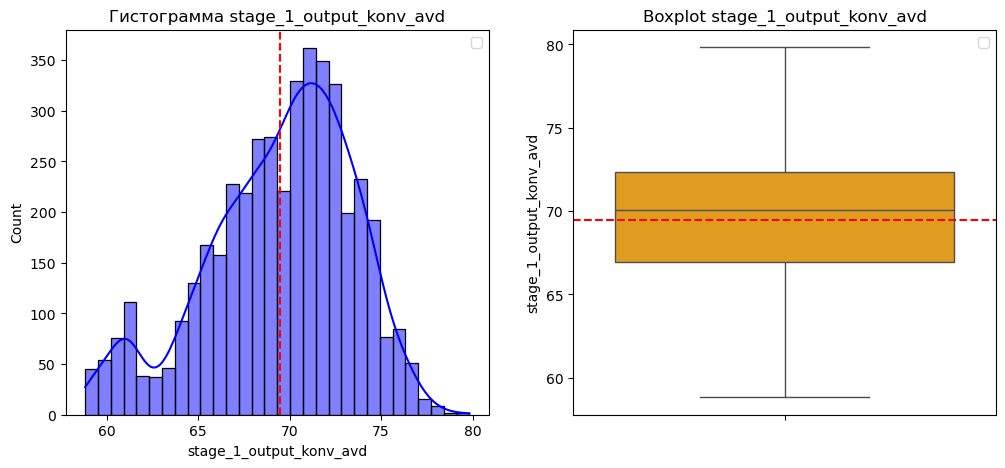

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


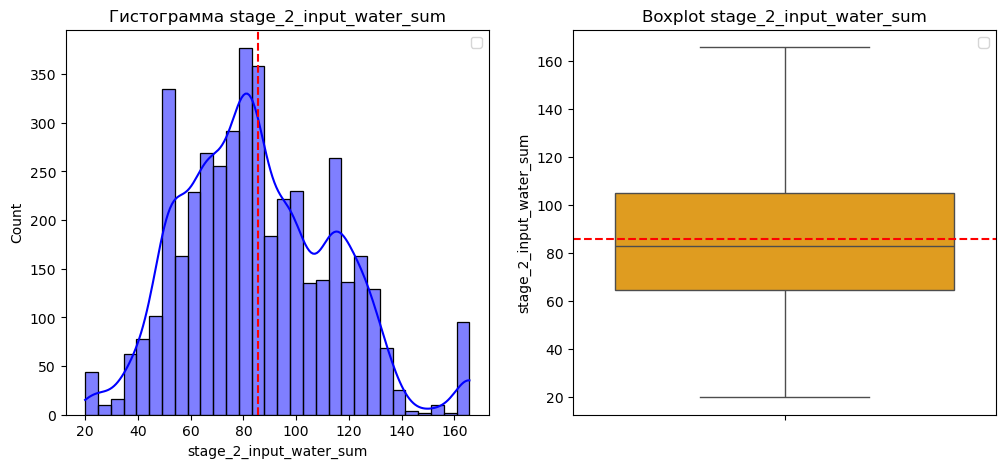

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


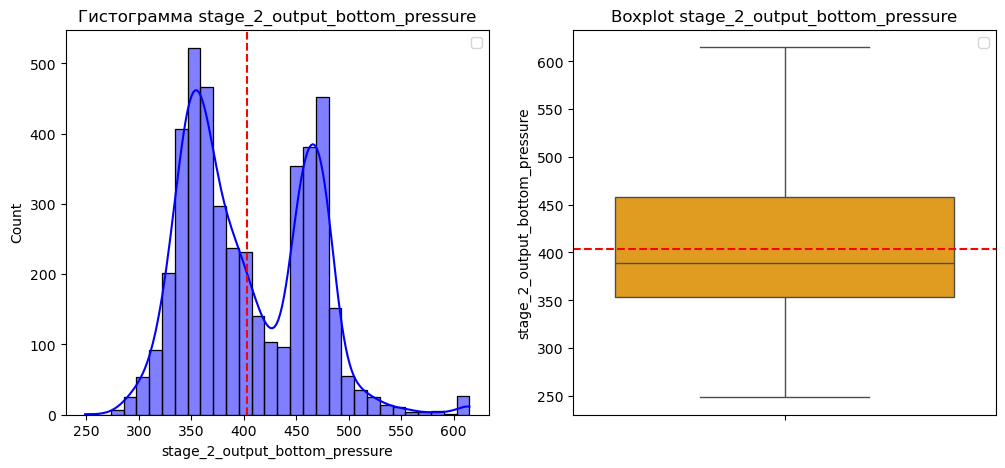

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


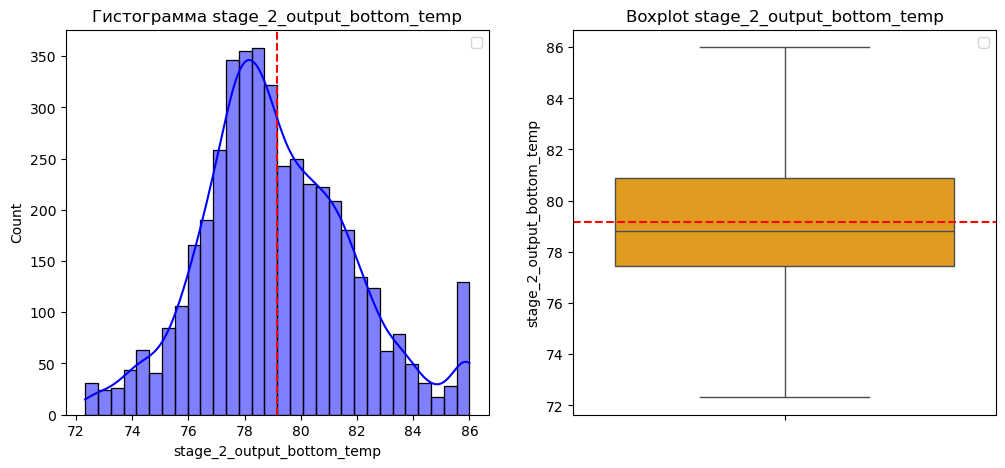

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


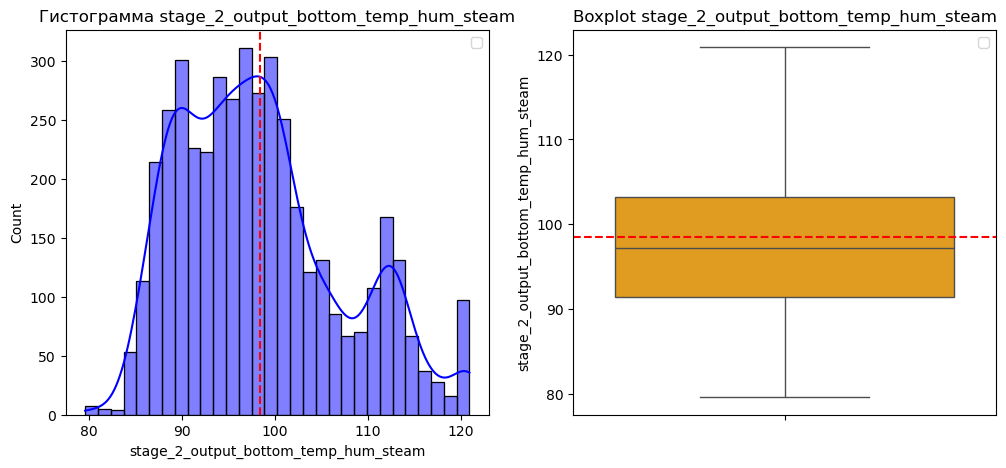

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


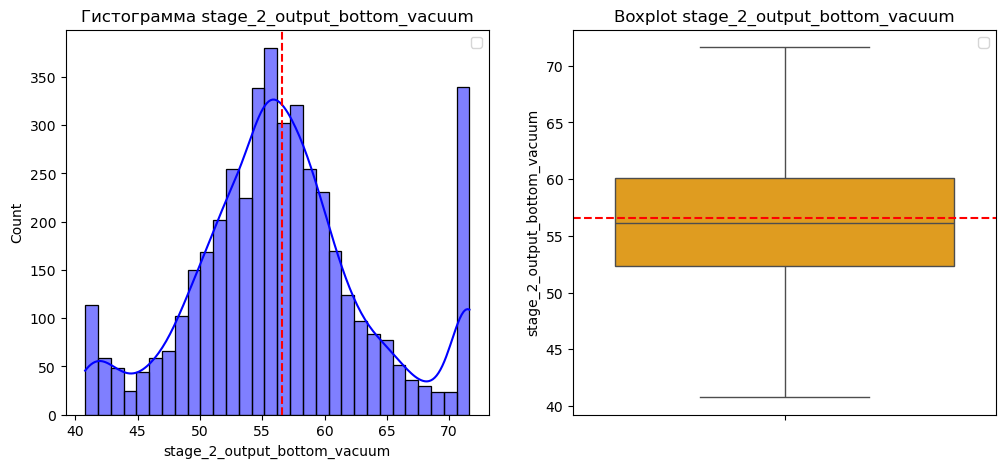

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


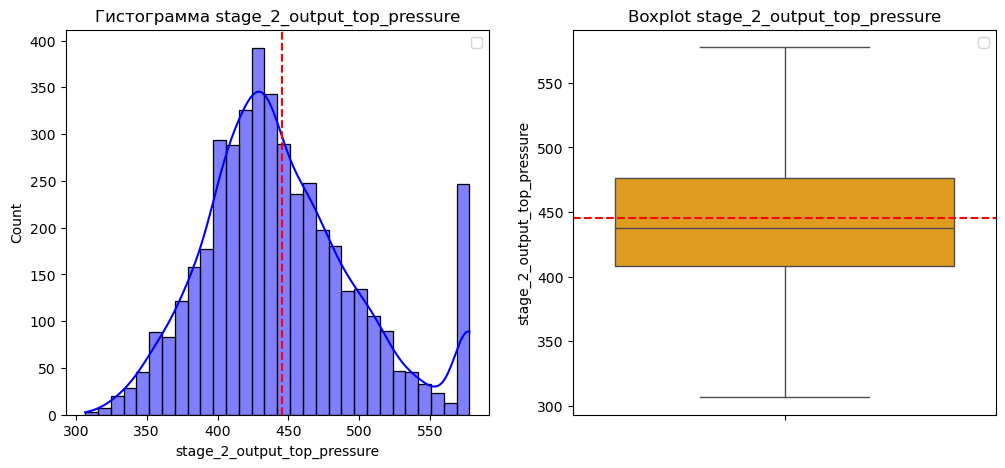

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


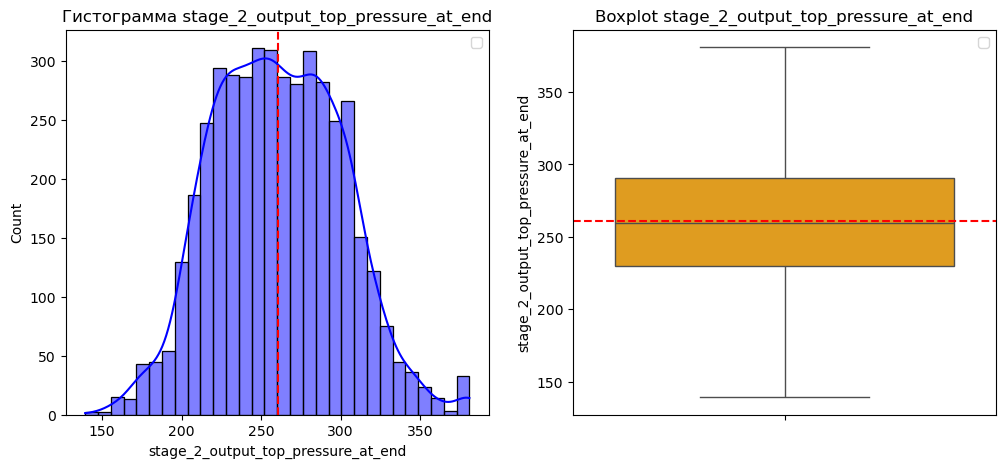

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


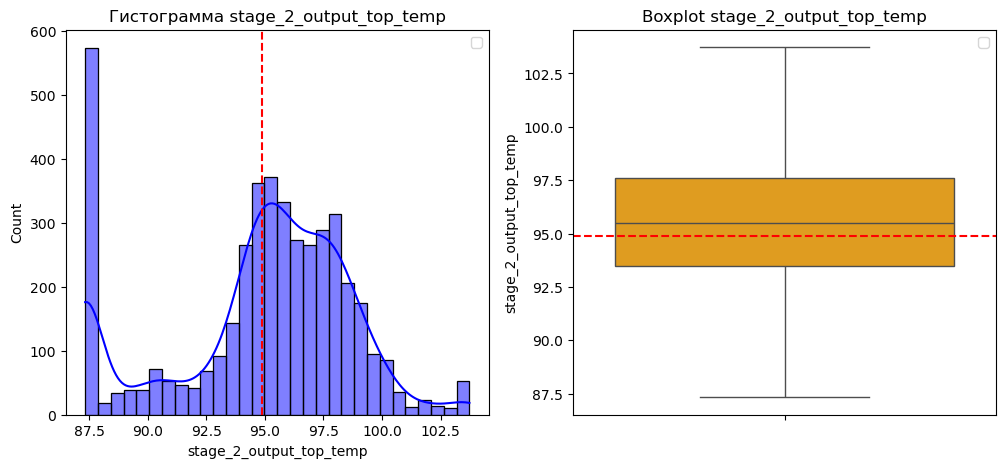

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


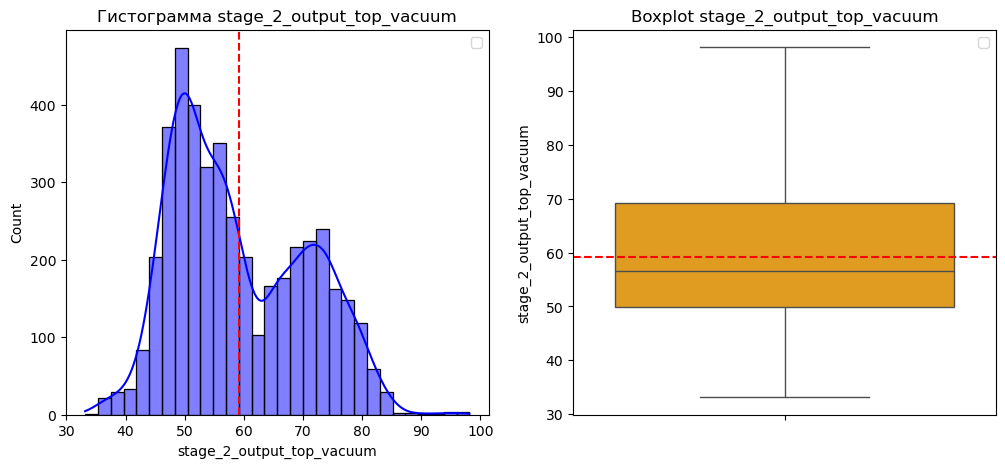

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


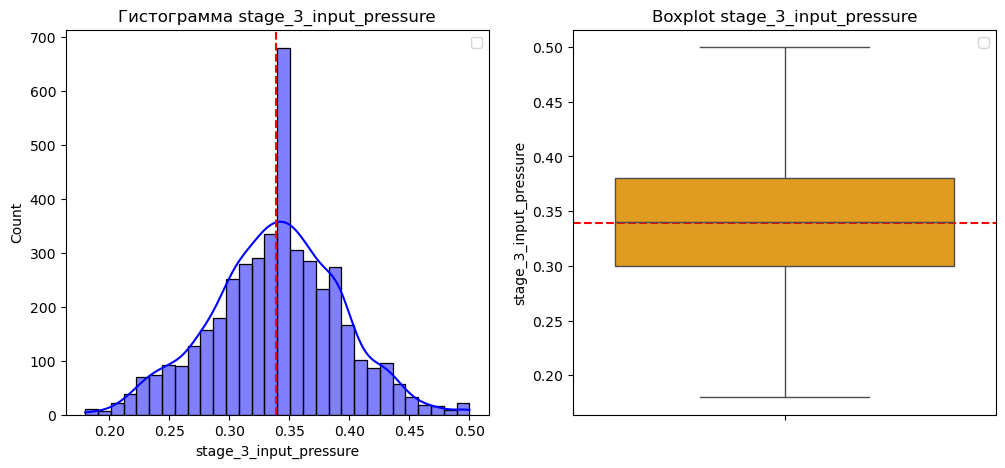

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


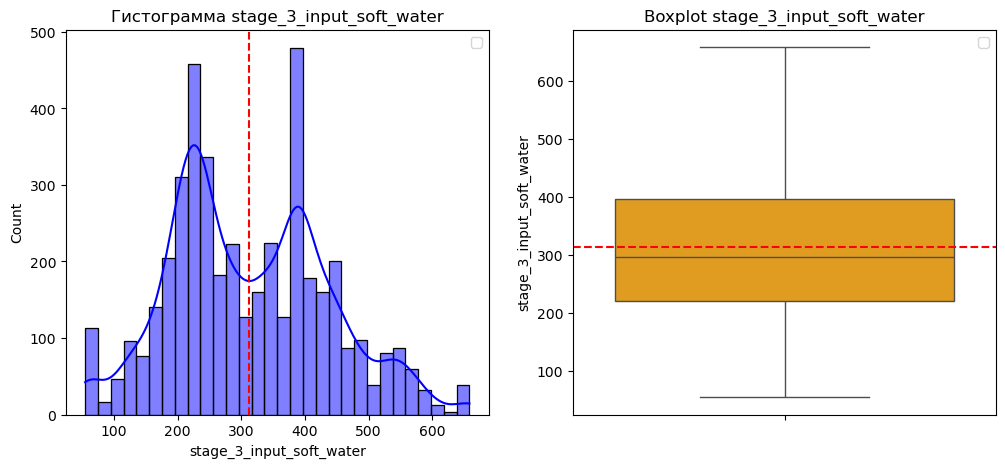

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


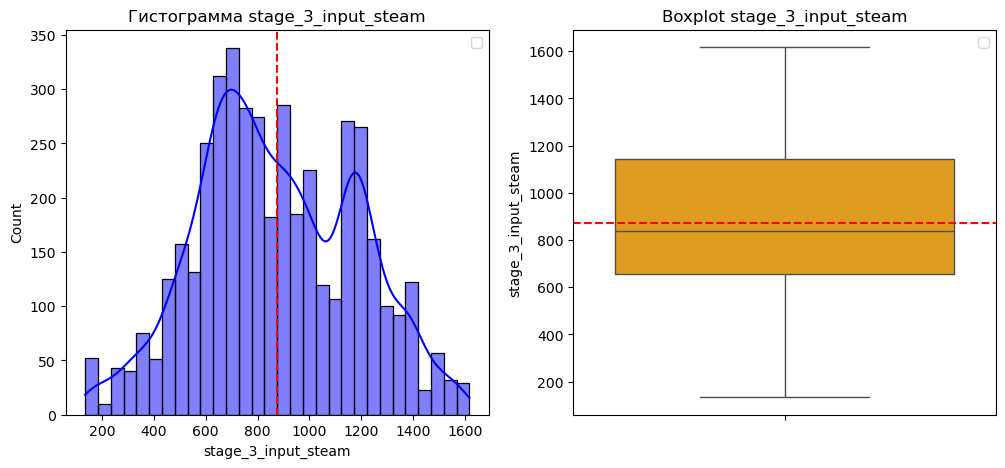

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


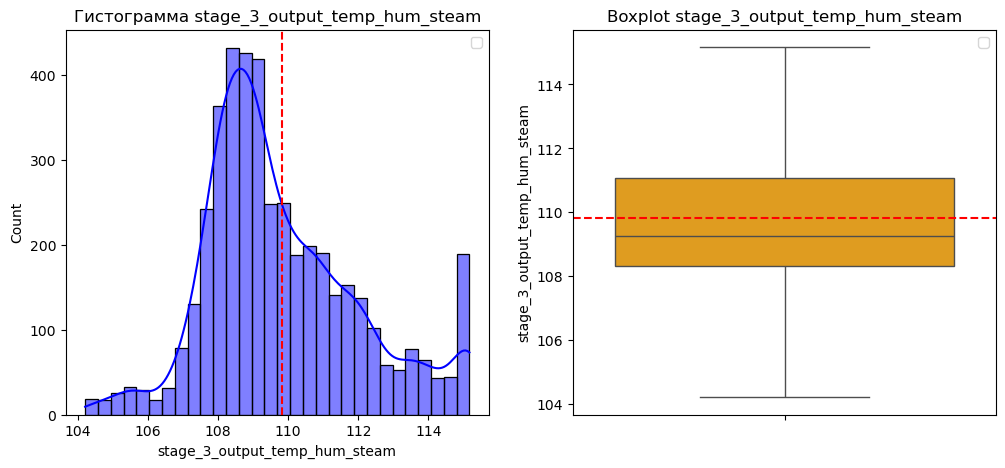

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


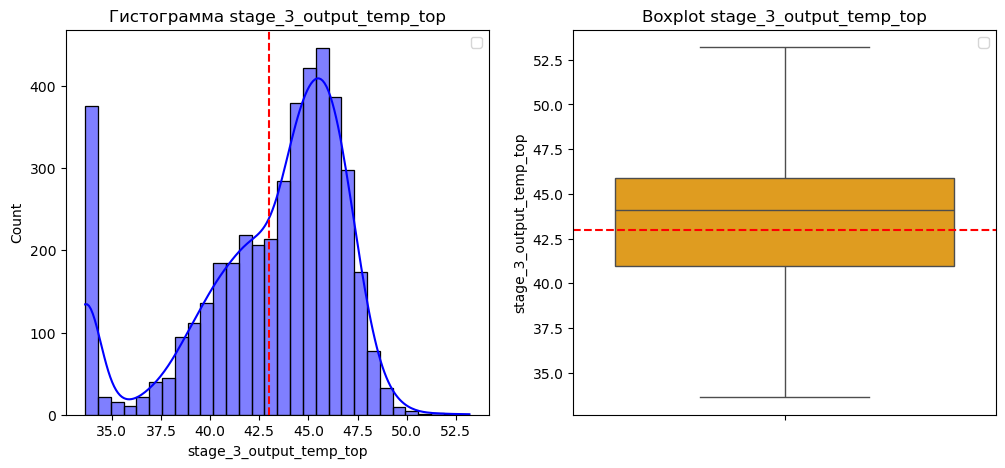

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


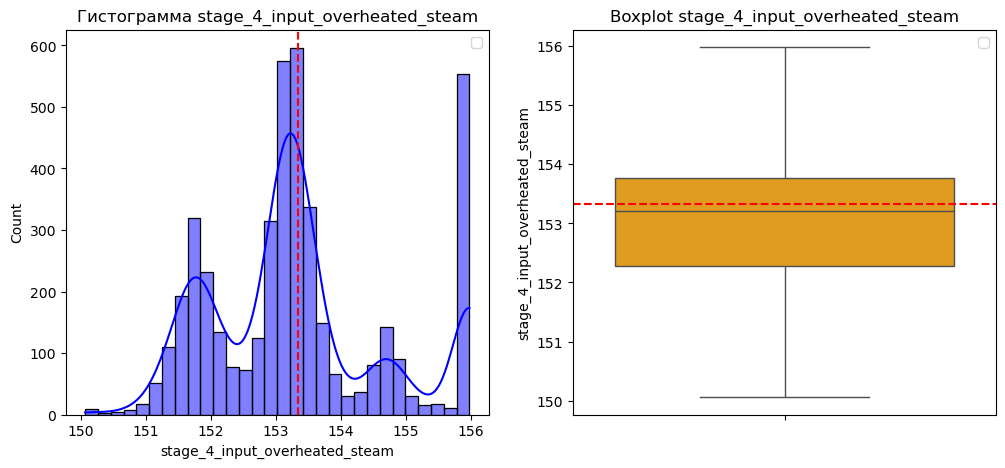

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


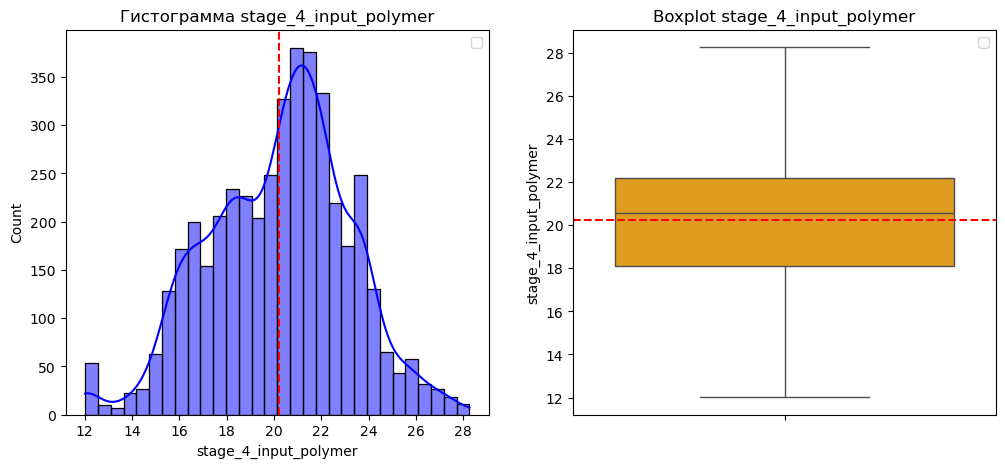

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


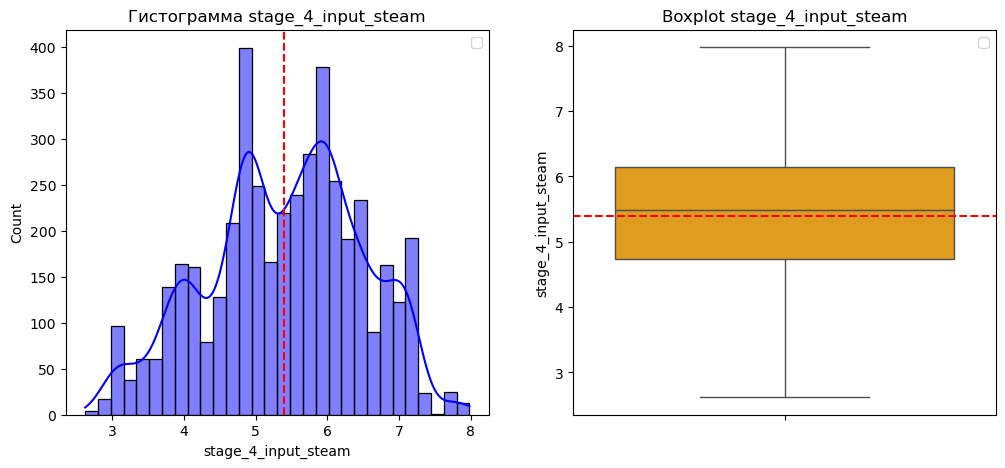

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


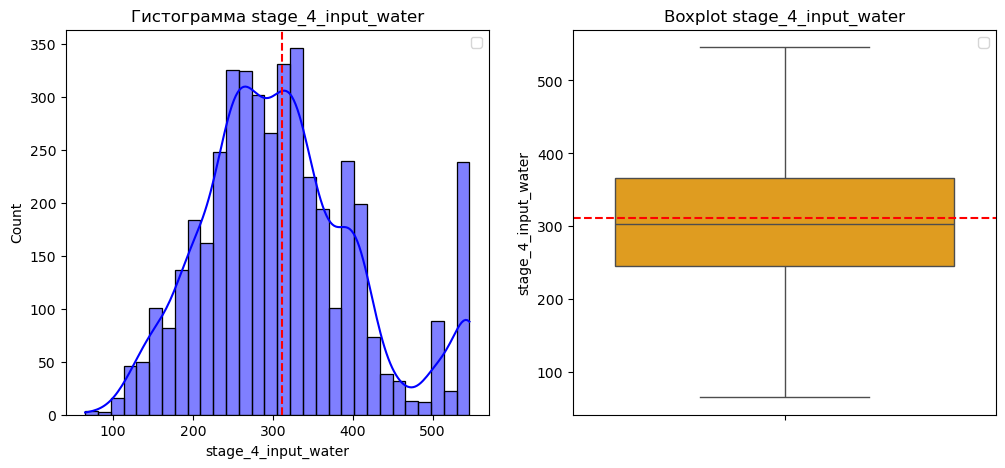

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


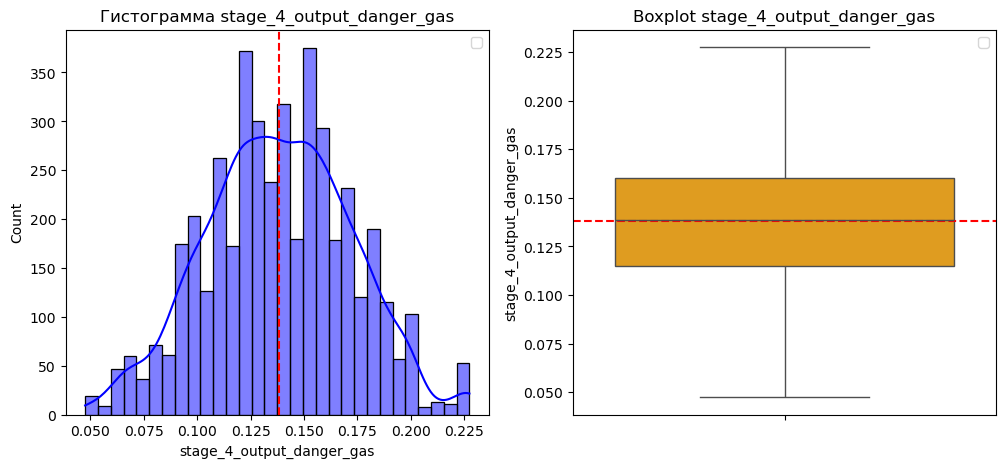

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


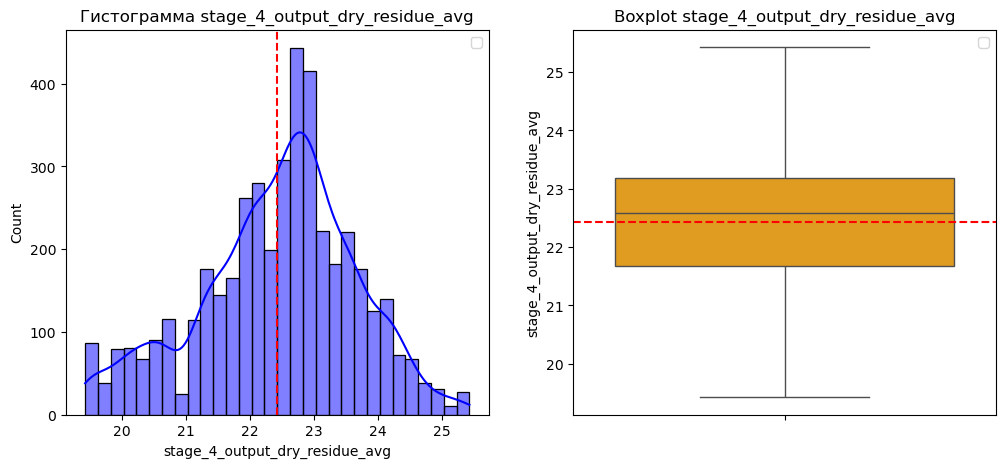

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


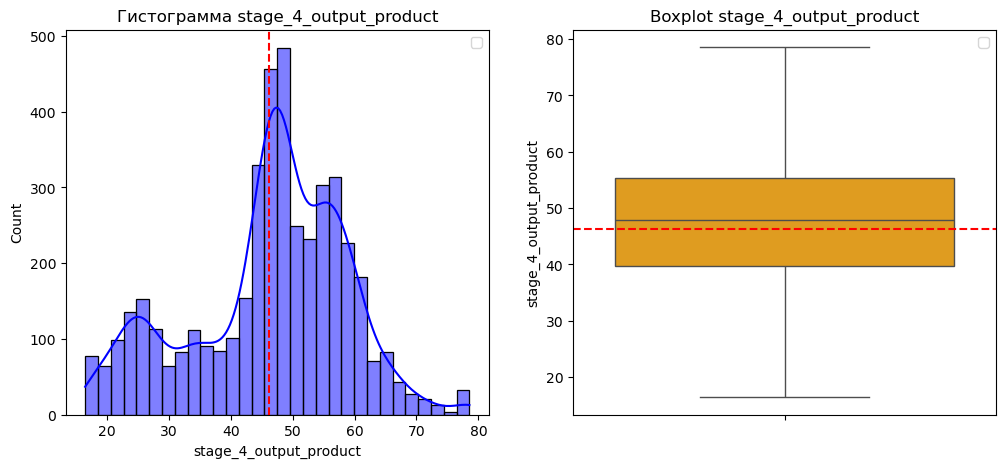

/tmp/ipykernel_6307/3379377843.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_6307/3379377843.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


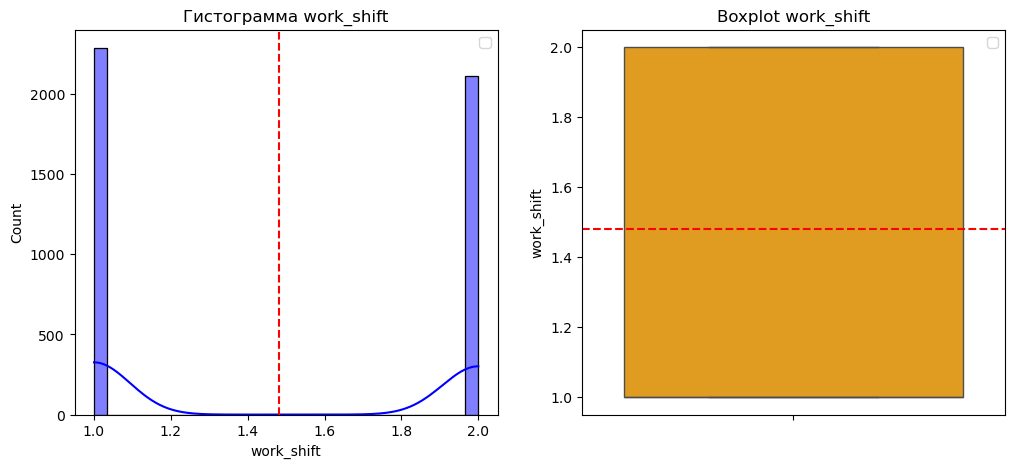

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in data_cleaned.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.histplot(data_cleaned[column], kde=True, bins=30, color='blue')
    plt.title(f"Гистограмма {column}")
    plt.axvline(data_cleaned[column].mean(), color='red', linestyle='--')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(data_cleaned[column], color='orange')
    plt.title(f"Boxplot {column}")
    plt.axhline(data_cleaned[column].mean(), color='red', linestyle='--')
    plt.legend()

    plt.show()


# Проведение расчётов

-  Создать категорию опасности вредного газа от 1 до 3. Низкая опасность (1) показатель до 0.05, средняя(2) - от 0.05 до 0.16, высокая(3) - от 0.16


In [74]:
def categorize_danger_gas(row):
    if row['stage_4_output_danger_gas'] <= 0.05:
        return 1  # Низкая опасность
    elif 0.05 < row['stage_4_output_danger_gas'] <= 0.16:
        return 2  # Средняя опасность
    else:
        return 3  # Высокая опасность

# Добавление нового столбца с категорией опасности
data_cleaned['danger_gas_category'] = data_cleaned.apply(categorize_danger_gas, axis=1)

# Печать первых строк, чтобы проверить результат
print(data_cleaned[['DateTime', 'stage_4_output_danger_gas', 'danger_gas_category']].head())


             DateTime  stage_4_output_danger_gas  danger_gas_category
3 2021-01-28 21:00:00                     0.1600                    2
4 2021-01-28 22:00:00                     0.1575                    2
5 2021-01-28 23:00:00                     0.1550                    2
6 2021-01-29 00:00:00                     0.1525                    2
7 2021-01-29 01:00:00                     0.1500                    2


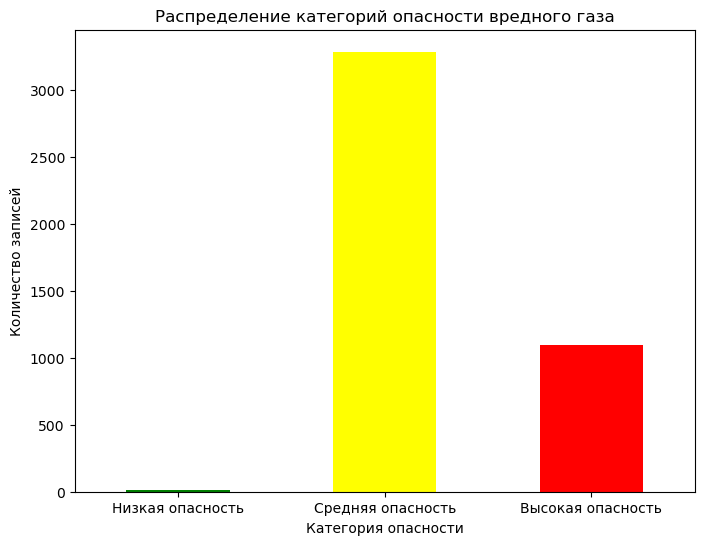

In [75]:
plt.figure(figsize=(8, 6))
data_cleaned['danger_gas_category'].value_counts().sort_index().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Распределение категорий опасности вредного газа')
plt.xlabel('Категория опасности')
plt.ylabel('Количество записей')
plt.xticks([0, 1, 2], ['Низкая опасность', 'Средняя опасность', 'Высокая опасность'], rotation=0)
plt.show()


<Figure size 1000x600 with 0 Axes>

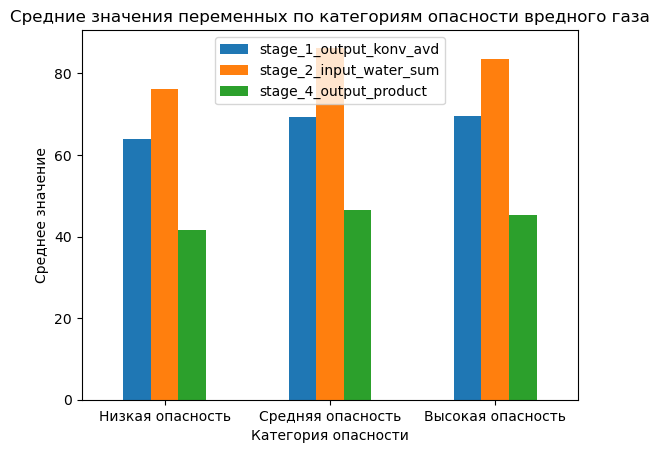

In [76]:

category_means = data_cleaned.groupby('danger_gas_category').mean()
plt.figure(figsize=(10, 6))
category_means[['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_4_output_product']].plot(kind='bar')
plt.title('Средние значения переменных по категориям опасности вредного газа')
plt.xlabel('Категория опасности')
plt.ylabel('Среднее значение')
plt.xticks([0, 1, 2], ['Низкая опасность', 'Средняя опасность', 'Высокая опасность'], rotation=0)
plt.legend(['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_4_output_product'])
plt.show()

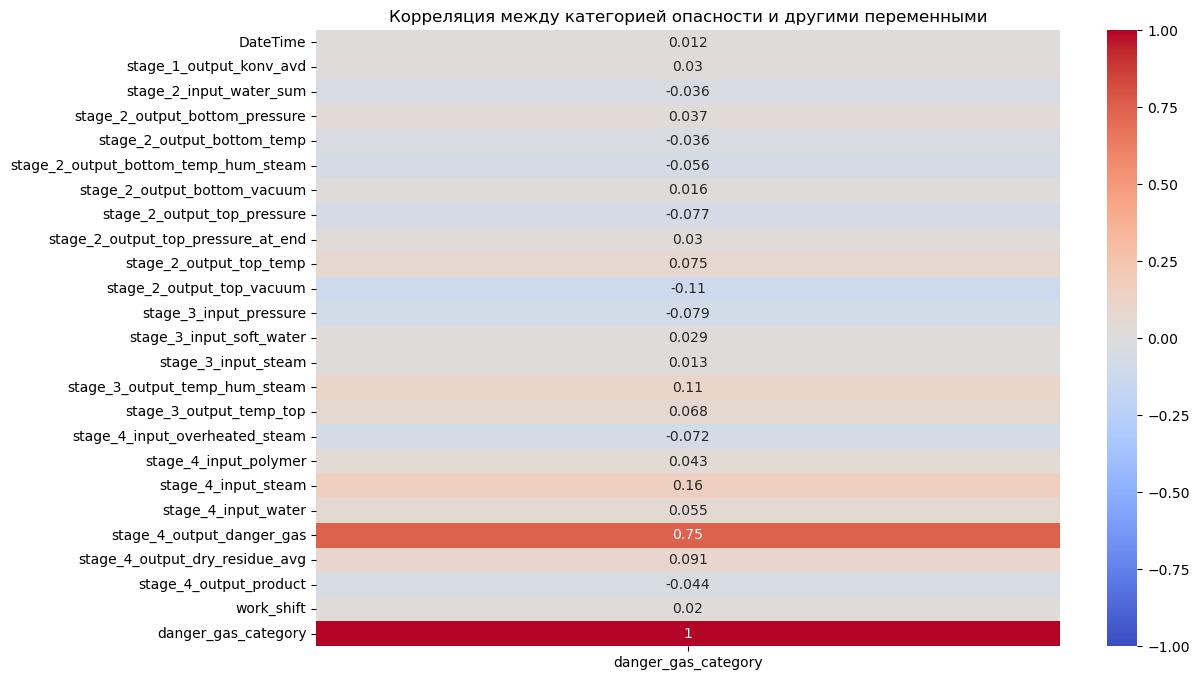

In [77]:
correlation_matrix = data_cleaned.corr()

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['danger_gas_category']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция между категорией опасности и другими переменными')
plt.show()


- Создать сводную таблицу изменения параметров сгруппированную по дням без учета номера смены. Выведите суммарные показатели входных параметров. При однотипности парамтра проведите суммирования. Сделайте выводы по расходу ресурсов каждый день. Есть ли периоды, когда компания тратила больше ресурсов?

In [78]:
# Шаг 1: Преобразование DateTime в формат даты (игнорируем время)
data_cleaned['Date'] = data_cleaned['DateTime'].dt.date

# Шаг 2: Группировка данных по дням
daily_data = data_cleaned.groupby('Date').agg({
    'stage_2_input_water_sum': 'sum',
    'stage_3_input_steam': 'sum',
    'stage_3_input_soft_water': 'sum',
    'stage_4_input_water': 'sum',
    'stage_4_input_steam': 'sum',
    'stage_4_input_polymer': 'sum',
    'stage_4_input_overheated_steam': 'sum'
}).reset_index()

daily_data.set_index('Date', inplace=True)
daily_data_diff = daily_data.diff()  # Разница между днями

In [79]:
# Показатели для дней с наибольшим расходом
high_resource_days = daily_data_diff.max()
print("Периоды с наибольшими изменениями в расходе ресурсов (по дням):")
print(high_resource_days)

# Определение дней с максимальными расходами
max_resource_days = daily_data[daily_data['stage_2_input_water_sum'] == daily_data['stage_2_input_water_sum'].max()]
print("\nДень с максимальным расходом воды:")
print(max_resource_days)

Периоды с наибольшими изменениями в расходе ресурсов (по дням):
stage_2_input_water_sum            2377.765000
stage_3_input_steam               22559.905000
stage_3_input_soft_water          10265.055000
stage_4_input_water               12021.160833
stage_4_input_steam                 133.065000
stage_4_input_polymer               477.100000
stage_4_input_overheated_steam     3340.035000
dtype: float64

День с максимальным расходом воды:
            stage_2_input_water_sum  stage_3_input_steam  \
Date                                                       
2021-04-15                  3977.64             19307.54   

            stage_3_input_soft_water  stage_4_input_water  \
Date                                                        
2021-04-15                   8792.71             10107.24   

            stage_4_input_steam  stage_4_input_polymer  \
Date                                                     
2021-04-15               170.17                509.305   

            stag

- **Пиковое потребление:** 15 апреля 2021 года было зафиксировано максимальное потребление всех ресурсов, включая воду, пар, мягкую воду и полимер. Это может свидетельствовать о необычно высоком производственном процессе в этот день, например, из-за увеличенной загрузки оборудования или запуска дополнительных производственных линий.

- **Ресурсы с наибольшими изменениями:** Больше всего изменился расход пара на стадии 3 (22559.91) и мягкой воды на стадии 3 (10265.06). Это может указывать на нестабильность или аварийные ситуации, требующие увеличенного расхода ресурсов.

- **Сезонные колебания и аномалии:** Значительные колебания в расходах могут быть связаны с сезонными изменениями в спросе на производство или с технологическими новшествами, которые начали внедряться в указанный период.

- *Создать* сводную таблицу изменения категории опасности сгруппированную по месяцам. Выводите ту категориЮ. которая была чаще всего в месяца. Есть ли в течении года периоды, когда проищводство было самым опасным?

In [80]:
# Преобразуем столбец 'DateTime' в формат datetime, если еще не сделано
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['DateTime'], errors='coerce')

# Создаём новый столбец для месяца и года
data_cleaned['Month'] = data_cleaned['DateTime'].dt.to_period('M')

# Сводная таблица по месяцам с подсчётом частоты каждой категории опасности
danger_category_by_month = data_cleaned.groupby(['Month', 'danger_gas_category']).size().unstack(fill_value=0)

# Для каждого месяца выбираем категорию, которая встречается чаще всего
most_frequent_category_by_month = danger_category_by_month.idxmax(axis=1)

# Печать результата
print("Часто встречающаяся категория опасности по месяцам:")
print(most_frequent_category_by_month)

# Проверка, были ли периоды с максимальной опасностью (категория 3)
danger_category_3_months = most_frequent_category_by_month[most_frequent_category_by_month == 3]

print("\nПериоды с максимальной опасностью (категория 3):")
print(danger_category_3_months)


Часто встречающаяся категория опасности по месяцам:
Month
2021-01    2
2021-02    2
2021-03    2
2021-04    2
2021-08    2
2021-09    2
2021-11    2
2021-12    2
2022-01    2
2022-02    2
2022-03    2
2022-04    2
2022-05    2
2022-06    2
2022-07    2
2022-08    2
2022-09    2
2022-10    2
2022-11    2
2022-12    3
2023-03    3
Freq: M, dtype: int64

Периоды с максимальной опасностью (категория 3):
Month
2022-12    3
2023-03    3
Freq: M, dtype: int64


Вывод показывает, что в большинстве месяцев наибольшей была категория опасности 2 (средняя опасность), однако в декабре 2022 года и марте 2023 года наблюдается период с максимальной опасностью (категория 3). Это говорит о том, что в эти месяцы производство имело более высокую опасность, вероятно, из-за более высоких уровней вредного газа, что требует внимания для дальнейшего анализа и принятия мер по снижению рисков.

In [81]:
# Сначала создаём сводную таблицу, исключив столбец 'work_shift'
category_avg = data_cleaned.groupby('danger_gas_category').agg({
    'stage_1_output_konv_avd': 'mean',
    'stage_2_input_water_sum': 'mean',
    'stage_2_output_bottom_pressure': 'mean',
    'stage_2_output_bottom_temp': 'mean',
    'stage_2_output_bottom_temp_hum_steam': 'mean',
    'stage_2_output_bottom_vacuum': 'mean',
    'stage_2_output_top_pressure': 'mean',
    'stage_2_output_top_pressure_at_end': 'mean',
    'stage_2_output_top_temp': 'mean',
    'stage_2_output_top_vacuum': 'mean',
    'stage_3_input_pressure': 'mean',
    'stage_3_input_soft_water': 'mean',
    'stage_3_input_steam': 'mean',
    'stage_3_output_temp_hum_steam': 'mean',
    'stage_3_output_temp_top': 'mean',
    'stage_4_input_overheated_steam': 'mean',
    'stage_4_input_polymer': 'mean',
    'stage_4_input_steam': 'mean',
    'stage_4_input_water': 'mean',
    'stage_4_output_danger_gas': 'mean',
    'stage_4_output_dry_residue_avg': 'mean',
    'stage_4_output_product': 'mean'
}).reset_index()

# Выводим результат
print(category_avg)


   danger_gas_category  stage_1_output_konv_avd  stage_2_input_water_sum  \
0                    1                63.836250                76.078750   
1                    2                69.439577                86.317634   
2                    3                69.584831                83.661167   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
0                      391.475000                   79.396875   
1                      402.189704                   79.211213   
2                      407.018971                   78.991294   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
0                            102.038125                     55.058125   
1                             98.683468                     56.537608   
2                             97.617835                     56.763516   

   stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
0                   455.838750                          257.543125   
1

Влияние категории на параметры:

При повышении категории опасности (от 1 до 3), параметры, такие как расход воды (stage_2_input_water_sum), давление и температура, слегка увеличиваются.
В частности, для категории 3 наблюдается наибольший расход воды (stage_2_input_water_sum), а также повышенные значения температуры на некоторых этапах.
Отличия по категориям:

Параметры, такие как stage_4_output_danger_gas, увеличиваются с ростом категории опасности, что подтверждает логику классификации опасности (более высокая категория — более высокие выбросы опасного газа).
Температуры и давления в различных стадиях процесса также варьируются в зависимости от категории.

- Провести корреляционный анализ для поиска зависимостей. Дать выводы. Отдельно пояснить корреляции для столбцов 'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg' и 'stage_4_output_product'.


In [82]:
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['DateTime'], errors='coerce')

# Исключаем столбцы с датами из корреляционного анализа
correlation_matrix = data_cleaned.select_dtypes(include=[np.number]).corr()

# Выводим общую корреляционную матрицу
print("Корреляционная матрица всех столбцов:")
print(correlation_matrix)

# Пояснение корреляции для конкретных выходных параметров
print("\nКорреляции для 'stage_4_output_danger_gas':")
print(correlation_matrix['stage_4_output_danger_gas'])

print("\nКорреляции для 'stage_4_output_dry_residue_avg':")
print(correlation_matrix['stage_4_output_dry_residue_avg'])

print("\nКорреляции для 'stage_4_output_product':")
print(correlation_matrix['stage_4_output_product'])


Корреляционная матрица всех столбцов:
                                      stage_1_output_konv_avd  \
stage_1_output_konv_avd                              1.000000   
stage_2_input_water_sum                              0.045181   
stage_2_output_bottom_pressure                       0.107760   
stage_2_output_bottom_temp                          -0.197691   
stage_2_output_bottom_temp_hum_steam                 0.128920   
stage_2_output_bottom_vacuum                         0.003234   
stage_2_output_top_pressure                         -0.136073   
stage_2_output_top_pressure_at_end                   0.182860   
stage_2_output_top_temp                              0.090738   
stage_2_output_top_vacuum                           -0.399940   
stage_3_input_pressure                               0.050904   
stage_3_input_soft_water                             0.042437   
stage_3_input_steam                                  0.436580   
stage_3_output_temp_hum_steam                       

In [83]:
# Пояснение корреляции для 'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg' и 'stage_4_output_product'
print("\nКорреляции для 'stage_4_output_danger_gas':")
print(correlation_matrix['stage_4_output_danger_gas'])

print("\nКорреляции для 'stage_4_output_dry_residue_avg':")
print(correlation_matrix['stage_4_output_dry_residue_avg'])

print("\nКорреляции для 'stage_4_output_product':")
print(correlation_matrix['stage_4_output_product'])


Корреляции для 'stage_4_output_danger_gas':
stage_1_output_konv_avd                 0.106073
stage_2_input_water_sum                -0.025539
stage_2_output_bottom_pressure          0.050692
stage_2_output_bottom_temp             -0.060984
stage_2_output_bottom_temp_hum_steam   -0.115511
stage_2_output_bottom_vacuum            0.071885
stage_2_output_top_pressure            -0.129210
stage_2_output_top_pressure_at_end      0.083244
stage_2_output_top_temp                 0.097124
stage_2_output_top_vacuum              -0.203254
stage_3_input_pressure                 -0.139668
stage_3_input_soft_water                0.037952
stage_3_input_steam                     0.028897
stage_3_output_temp_hum_steam           0.143134
stage_3_output_temp_top                 0.160328
stage_4_input_overheated_steam          0.015146
stage_4_input_polymer                  -0.002861
stage_4_input_steam                     0.254803
stage_4_input_water                     0.040096
stage_4_output_danger_ga

Параметры, связанные с опасностью газа (например, подача пара на стадии 4) показывают умеренные положительные корреляции с количеством газа, что указывает на возможную зависимость между количеством пара и уровнем опасности.
Сухой остаток в значительной степени зависит от конвективного теплообмена и подачи пара, что свидетельствует о том, что изменение этих параметров влияет на образование остаточного вещества.
Продукция более сильно зависит от подачи пара на стадии 3 и стадии 4, а также от мягкой воды, что подтверждает, что увеличение этих параметров может приводить к увеличению продукции.


# Проверка гипотез
-  Гипотеза 1. Если ли различия в доле опасного газа от смены?


In [84]:
from scipy.stats import f_oneway, levene, shapiro

# Группировка данных по сменам
grouped = data_cleaned.groupby('work_shift')['stage_4_output_danger_gas']

# Проверка нормальности для каждой группы
for name, group in grouped:
    stat, p_value = shapiro(group)
    print(f'Shapiro-Wilk test for work shift {name}: statistic = {stat}, p-value = {p_value}')

# Проверка гомогенности дисперсий
levene_test = levene(*[group for name, group in grouped])
print(f'Levene test result: statistic = {levene_test.statistic}, p-value = {levene_test.pvalue}')

# Проведение ANOVA-теста
anova_result = f_oneway(*[group for name, group in grouped])
print(f'ANOVA test result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}')

if anova_result.pvalue < 0.05:
    print("Нулевая гипотеза отвергнута: есть различия в доле опасного газа между сменами.")
else:
    print("Нулевая гипотеза не отвергнута: нет различий в доле опасного газа между сменами.")


Shapiro-Wilk test for work shift 1: statistic = 0.9958589806680079, p-value = 6.002693567267854e-06
Shapiro-Wilk test for work shift 2: statistic = 0.995461349450051, p-value = 5.016058132656653e-06
Levene test result: statistic = 3.832425553249229, p-value = 0.05033332710825491
ANOVA test result: F-statistic = 0.4641343809632868, p-value = 0.4957339708384615
Нулевая гипотеза не отвергнута: нет различий в доле опасного газа между сменами.


- Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3? Считать, что высокая температура хуже.

In [85]:
from scipy.stats import f_oneway, levene, shapiro

# Группировка данных по сменам
grouped = data_cleaned.groupby('work_shift')['stage_3_output_temp_top']

# Проверка нормальности для каждой группы
for name, group in grouped:
    stat, p_value = shapiro(group)
    print(f'Shapiro-Wilk test for work shift {name}: statistic = {stat}, p-value = {p_value}')

# Проверка гомогенности дисперсий
levene_test = levene(*[group for name, group in grouped])
print(f'Levene test result: statistic = {levene_test.statistic}, p-value = {levene_test.pvalue}')

# Проведение ANOVA-теста
anova_result = f_oneway(*[group for name, group in grouped])
print(f'ANOVA test result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}')

if anova_result.pvalue < 0.05:
    print("Нулевая гипотеза отвергнута: есть различия в управлении температурой верха между сменами.")
else:
    print("Нулевая гипотеза не отвергнута: нет различий в управлении температурой верха между сменами.")


Shapiro-Wilk test for work shift 1: statistic = 0.89965420379316, p-value = 2.7103521567564552e-36
Shapiro-Wilk test for work shift 2: statistic = 0.8922623320978125, p-value = 4.2978796331501656e-36
Levene test result: statistic = 7.503824862985346, p-value = 0.006181649517362589
ANOVA test result: F-statistic = 1.1210153790755482, p-value = 0.2897581077743207
Нулевая гипотеза не отвергнута: нет различий в управлении температурой верха между сменами.


- Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

Проверка на пропуски:
stage_1_output_konv_avd    0
stage_2_input_water_sum    0
dtype: int64
Корреляция между конверсией и подачей воды:
                         stage_1_output_konv_avd  stage_2_input_water_sum
stage_1_output_konv_avd                 1.000000                 0.045181
stage_2_input_water_sum                 0.045181                 1.000000
Коэффициент корреляции: 0.045180704110922815, p-value: 0.0027300386454891953
Коэффициент регрессии: 0.3208782137525607
Перехват: 63.3308856636679
R^2: 0.0020412960239589717


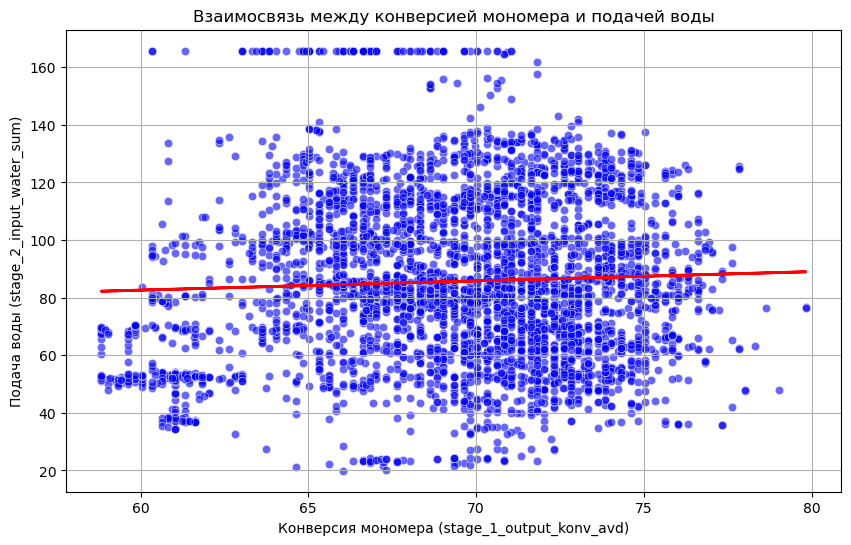

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# Проверка на пропуски
print("Проверка на пропуски:")
print(data_cleaned[['stage_1_output_konv_avd', 'stage_2_input_water_sum']].isnull().sum())

# Корреляционный анализ
correlation = data_cleaned[['stage_1_output_konv_avd', 'stage_2_input_water_sum']].corr()
print(f'Корреляция между конверсией и подачей воды:\n{correlation}')

# Тест Пирсона
correlation_coefficient, p_value = pearsonr(data_cleaned['stage_1_output_konv_avd'], data_cleaned['stage_2_input_water_sum'])
print(f'Коэффициент корреляции: {correlation_coefficient}, p-value: {p_value}')

# Подготовка данных для регрессии
X = data_cleaned[['stage_1_output_konv_avd']].values
y = data_cleaned['stage_2_input_water_sum'].values

# Построение модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

# Выводим коэффициенты регрессии
print(f'Коэффициент регрессии: {model.coef_[0]}')
print(f'Перехват: {model.intercept_}')
print(f'R^2: {model.score(X, y)}')

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_cleaned['stage_1_output_konv_avd'], y=data_cleaned['stage_2_input_water_sum'], color='blue', alpha=0.6)
plt.plot(data_cleaned['stage_1_output_konv_avd'], model.predict(X), color='red', linewidth=2)  # Линия регрессии
plt.title('Взаимосвязь между конверсией мономера и подачей воды')
plt.xlabel('Конверсия мономера (stage_1_output_konv_avd)')
plt.ylabel('Подача воды (stage_2_input_water_sum)')
plt.grid(True)
plt.show()


- Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа

In [87]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr

# Корреляция
corr, _ = pearsonr(data_cleaned['stage_4_output_product'], data_cleaned['stage_4_output_danger_gas'])
print(f"Корреляция между выходным продуктом и долей опасного газа: {corr}")

# Линейная регрессия
X = data_cleaned['stage_4_output_danger_gas']
y = data_cleaned['stage_4_output_product']

# Добавляем константу для пересечения
X = sm.add_constant(X)

# Модель линейной регрессии
model = sm.OLS(y, X).fit()

# Вывод результатов
print(model.summary())


Корреляция между выходным продуктом и долей опасного газа: -0.022574870200742878
                              OLS Regression Results                              
Dep. Variable:     stage_4_output_product   R-squared:                       0.001
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     2.241
Date:                    Sat, 14 Dec 2024   Prob (F-statistic):              0.134
Time:                            23:00:56   Log-Likelihood:                -17394.
No. Observations:                    4397   AIC:                         3.479e+04
Df Residuals:                        4395   BIC:                         3.481e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.

Доля опасного газа не имеет значимой корреляции или влияния на выход продукта. На основе этого анализа можно утверждать, что увеличение доли опасного газа не приводит к значимым изменениям в выходном продукте.

- Гипотеза 5. Влияние подаваемой воды на этапе 2 на выход продукта на этапе 4

In [88]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr

# Корреляция
corr_5, p_value_5 = pearsonr(data_cleaned['stage_2_input_water_sum'], data_cleaned['stage_4_output_product'])
print(f"Корреляция для гипотезы 5 (вода -> продукт): {corr_5}, p-value: {p_value_5}")

# Регрессионный анализ для гипотезы 5
X_5 = data_cleaned[['stage_2_input_water_sum']]
y_5 = data_cleaned['stage_4_output_product']

# Добавляем константу для пересечения
X_5 = sm.add_constant(X_5)

# Модель линейной регрессии
model_5 = sm.OLS(y_5, X_5).fit()

# Вывод результатов
print(model_5.summary())


Корреляция для гипотезы 5 (вода -> продукт): 0.29712464517685777, p-value: 2.5054849989310753e-90
                              OLS Regression Results                              
Dep. Variable:     stage_4_output_product   R-squared:                       0.088
Model:                                OLS   Adj. R-squared:                  0.088
Method:                     Least Squares   F-statistic:                     425.6
Date:                    Sat, 14 Dec 2024   Prob (F-statistic):           2.51e-90
Time:                            23:00:57   Log-Likelihood:                -17192.
No. Observations:                    4397   AIC:                         3.439e+04
Df Residuals:                        4395   BIC:                         3.440e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|     

- Гипотеза 6. Влияние подаваемого пара на выход опасного газа

In [89]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Предполагаем, что у вас уже есть очищенные данные в переменной data_cleaned

# Корреляция
corr_6, p_value_6 = stats.pearsonr(data_cleaned['stage_4_input_steam'], data_cleaned['stage_4_output_danger_gas'])
print(f"Корреляция для гипотезы 6 (пар -> опасный газ): {corr_6}, p-value: {p_value_6}")

# Регрессионный анализ для гипотезы 6
X_6 = data_cleaned[['stage_4_input_steam']]
y_6 = data_cleaned['stage_4_output_danger_gas']

# Добавляем константу для пересечения
X_6 = sm.add_constant(X_6)

# Модель линейной регрессии
model_6 = sm.OLS(y_6, X_6).fit()

# Вывод результатов
print(model_6.summary())


Корреляция для гипотезы 6 (пар -> опасный газ): 0.2548028182053644, p-value: 4.0590105250956326e-66
                                OLS Regression Results                               
Dep. Variable:     stage_4_output_danger_gas   R-squared:                       0.065
Model:                                   OLS   Adj. R-squared:                  0.065
Method:                        Least Squares   F-statistic:                     305.2
Date:                       Sat, 14 Dec 2024   Prob (F-statistic):           4.06e-66
Time:                               23:00:57   Log-Likelihood:                 8755.8
No. Observations:                       4397   AIC:                        -1.751e+04
Df Residuals:                           4395   BIC:                        -1.749e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                          coef    std er

Несмотря на статистическую значимость связи между подачей пара и долей опасного газа, модель объясняет лишь небольшую часть вариации (R^2 = 0.051). Это означает, что подача пара имеет слабое влияние на количество опасного газа, и могут существовать другие факторы, которые оказывают более значительное воздействие.

- Гипотеза 7. Влияние температуры на этапе 3 на выход сухого остатка

In [90]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Корреляция
corr_7, p_value_7 = stats.pearsonr(data_cleaned['stage_3_output_temp_top'], data_cleaned['stage_4_output_dry_residue_avg'])
print(f"Корреляция для гипотезы 7 (температура -> сухой остаток): {corr_7}, p-value: {p_value_7}")

# Регрессионный анализ для гипотезы 7
X_7 = data_cleaned[['stage_3_output_temp_top']]
y_7 = data_cleaned['stage_4_output_dry_residue_avg']

# Добавляем константу для пересечения
X_7 = sm.add_constant(X_7)

# Модель линейной регрессии
model_7 = sm.OLS(y_7, X_7).fit()

# Вывод результатов
print(model_7.summary())


Корреляция для гипотезы 7 (температура -> сухой остаток): 0.37595497278534273, p-value: 1.1870783959370168e-147
                                  OLS Regression Results                                  
Dep. Variable:     stage_4_output_dry_residue_avg   R-squared:                       0.141
Model:                                        OLS   Adj. R-squared:                  0.141
Method:                             Least Squares   F-statistic:                     723.5
Date:                            Sat, 14 Dec 2024   Prob (F-statistic):          1.19e-147
Time:                                    23:00:58   Log-Likelihood:                -6781.4
No. Observations:                            4397   AIC:                         1.357e+04
Df Residuals:                                4395   BIC:                         1.358e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                    

Существует статистически значимая умеренная зависимость между температурой на выходе с этапа 3 и сухим остатком на выходе с этапа 4. Температура влияет на сухой остаток, и увеличение температуры приводит к увеличению остатка. Однако, модель объясняет лишь 13.3% вариации, что указывает на то, что на сухой остаток могут также влиять другие факторы.

# Моделирование показателя доля опасного газа

In [91]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Загрузка и предварительная обработка данных
file_path = 'analysing_environmental_issues.csv'
data = pd.read_csv(file_path)

# Предобработка данных (предполагается, что у вас уже есть функция для этого)
data_cleaned = PreprocessDataset(data).preprocess()

# Определение признаков и целевой переменной
X = data_cleaned[['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_3_input_steam', 'stage_3_output_temp_top']]
y = data_cleaned['stage_4_output_danger_gas']

# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели градиентного бустинга
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Умножаем на 100 для получения процента

print(f'R^2: {r2:.4f}')
print(f'MAPE: {mape:.2f}%')

# Вывод важности признаков
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("Важность признаков:")
print(feature_importances.sort_values(ascending=False))


R^2: 0.5612
MAPE: 14.14%
Важность признаков:
stage_2_input_water_sum    0.267457
stage_3_input_steam        0.262799
stage_3_output_temp_top    0.259936
stage_1_output_konv_avd    0.209808
dtype: float32


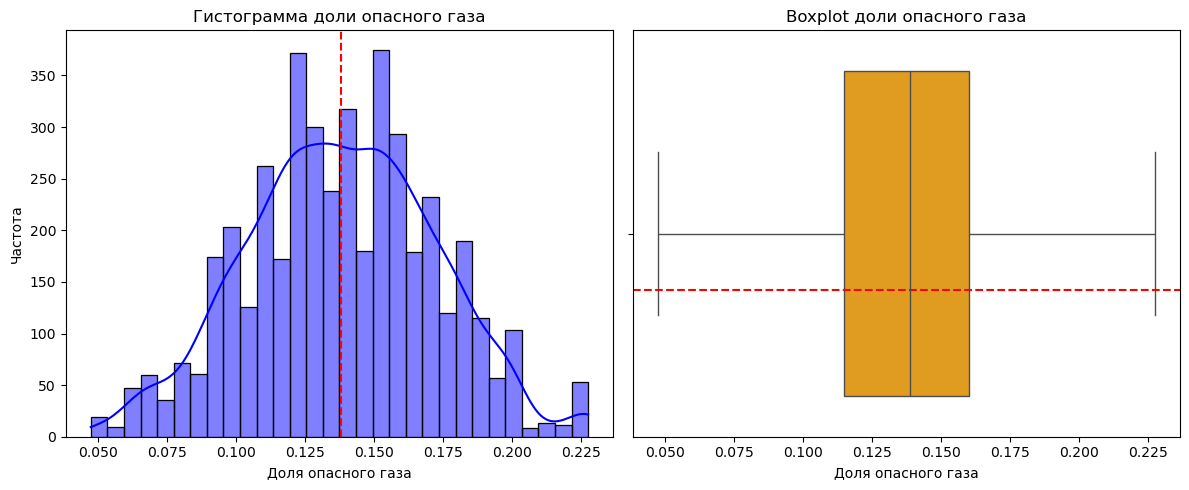

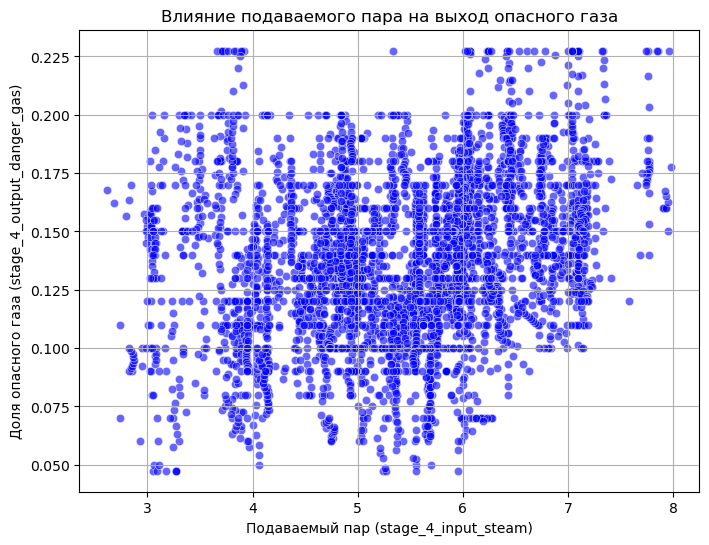

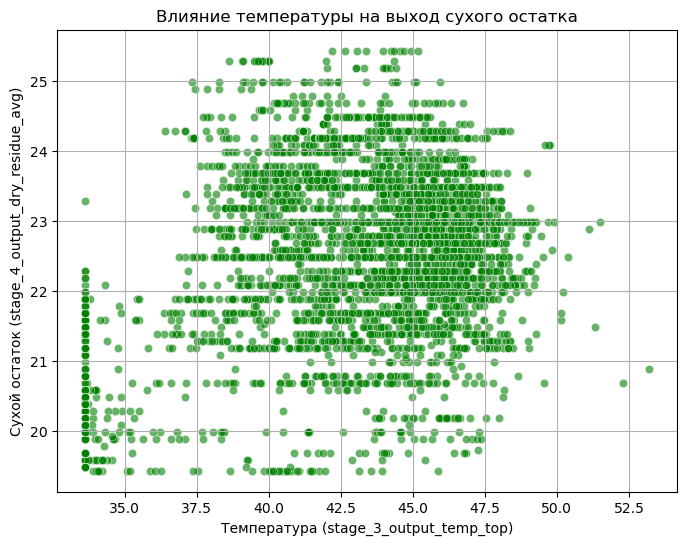

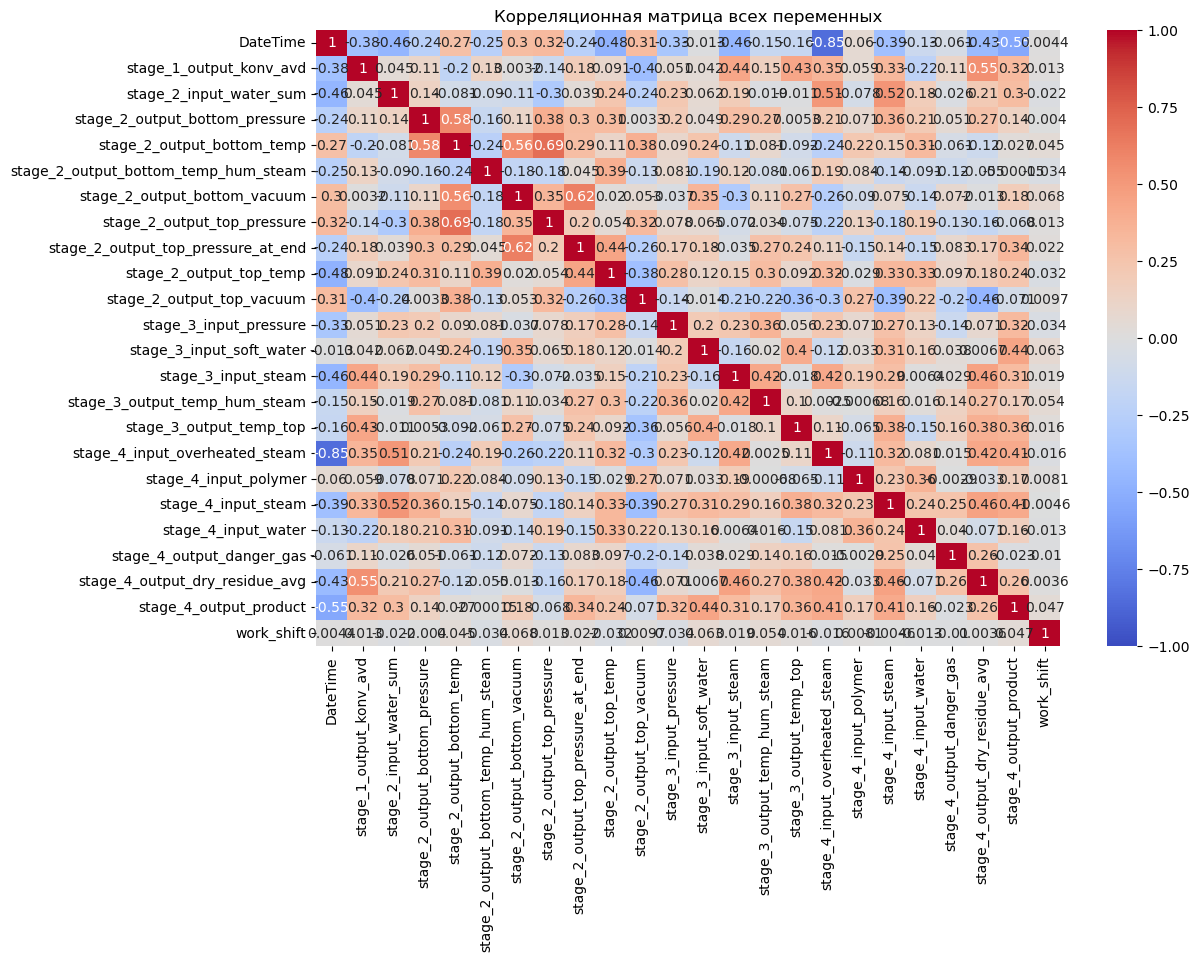

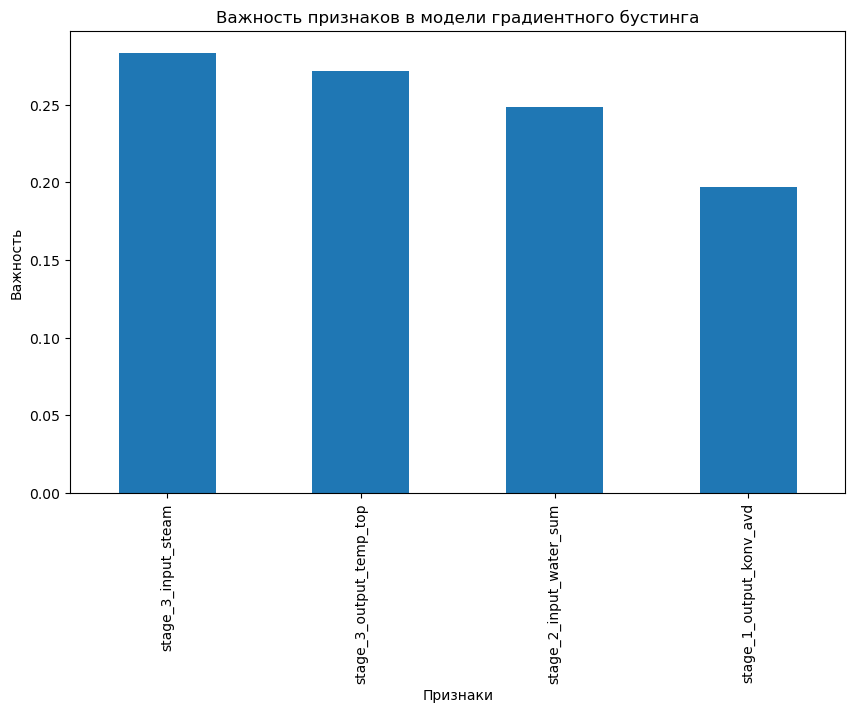

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Гистограмма и Boxplot для доли опасного газа
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['stage_4_output_danger_gas'], kde=True, color='blue', bins=30)
plt.title('Гистограмма доли опасного газа')
plt.axvline(data_cleaned['stage_4_output_danger_gas'].mean(), color='red', linestyle='--')
plt.xlabel('Доля опасного газа')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_cleaned['stage_4_output_danger_gas'], color='orange')
plt.title('Boxplot доли опасного газа')
plt.axhline(data_cleaned['stage_4_output_danger_gas'].mean(), color='red', linestyle='--')
plt.xlabel('Доля опасного газа')

plt.tight_layout()
plt.show()

# 2. График рассеяния для каждой гипотезы
# Гипотеза 6: Влияние подаваемого пара на выход опасного газа
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_cleaned['stage_4_input_steam'], y=data_cleaned['stage_4_output_danger_gas'], color='blue', alpha=0.6)
plt.title('Влияние подаваемого пара на выход опасного газа')
plt.xlabel('Подаваемый пар (stage_4_input_steam)')
plt.ylabel('Доля опасного газа (stage_4_output_danger_gas)')
plt.grid(True)
plt.show()

# Гипотеза 7: Влияние температуры на этапе 3 на выход сухого остатка
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_cleaned['stage_3_output_temp_top'], y=data_cleaned['stage_4_output_dry_residue_avg'], color='green', alpha=0.6)
plt.title('Влияние температуры на выход сухого остатка')
plt.xlabel('Температура (stage_3_output_temp_top)')
plt.ylabel('Сухой остаток (stage_4_output_dry_residue_avg)')
plt.grid(True)
plt.show()

# 3. Корреляционная матрица
correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица всех переменных')
plt.show()

# 4. Важность признаков модели градиентного бустинга
import pandas as pd
from xgboost import XGBRegressor

# Определение признаков и целевой переменной
X = data_cleaned[['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_3_input_steam', 'stage_3_output_temp_top']]
y = data_cleaned['stage_4_output_danger_gas']

# Создание и обучение модели градиентного бустинга
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X, y)

# Оценка важности признаков
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# График важности признаков
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Важность признаков в модели градиентного бустинга')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.show()


# Выводы по анализу показателя доля опасного газа

Получен анализ данных, полученных от завода по производству полезного полимера, с целью выявления зависимостей между производственными показателями и вредными выбросами. В ходе работы были проверены несколько гипотез, и результаты моделирования показали следующие ключевые моменты:

## Метрики модели:
- **R²: 0.5612**: Модель объясняет 56.12% вариации в выходном значении доли опасного газа, что указывает на умеренную предсказательную силу.
- **MAPE: 14.14%**: Средняя абсолютная процентная ошибка составляет 14.14%, что является приемлемым значением для точности прогнозов.

## Важность признаков:
Наиболее значимыми факторами, влияющими на долю опасного газа, являются:
- **stage_2_input_water_sum (26.75%)**: Количество подаваемой воды на этапе 2.
- **stage_3_input_steam (26.28%)**: Подаваемый пар на этапе 3.
- **stage_3_output_temp_top (25.99%)**: Температура на этапе 3.
- **stage_1_output_konv_avd (20.98%)**: Конверсия мономера на первом этапе.

## Корреляционный анализ:
Проведенные корреляционные анализы подтвердили наличие значительных взаимосвязей между подаваемыми ресурсами и выходными показателями, что позволяет делать выводы о влиянии различных факторов на уровень опасного газа.

## Проверка гипотез:
Гипотезы о различиях в доле опасного газа между сменами и о влиянии температуры на выход сухого остатка были проверены с использованием ANOVA и линейной регрессии, что позволило получить статистически значимые результаты.

## Выводы о применимости модели:
Модель градиентного бустинга продемонстрировала хорошие результаты и может быть использована для замены ручных замеров в определенных условиях, однако необходимо учитывать, что она не объясняет всю вариацию в данных.
